# Сверточная нейросеть для решения задачи классификации картинок

На этом практическом занятии мы будем решать задачу классификации картинок CIFAR на 10 классов с помощью сверточных нейросетей. 


![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

## Загрузка датасета


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms

Датасет CIFAR — один из стандартных, поэтому он есть в модуле datasets библиотеки torchvision. И загрузить его очень просто:

In [2]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10_data
    Split: Train
    StandardTransform
Transform: ToTensor()

Поделим train_data на тренировочную и валидационную выборку:

In [4]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Заведем DataLoader'ы для каждой части датасета:

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Посмотрим на несколько картинок:

In [6]:
for batch in train_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [7]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [8]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

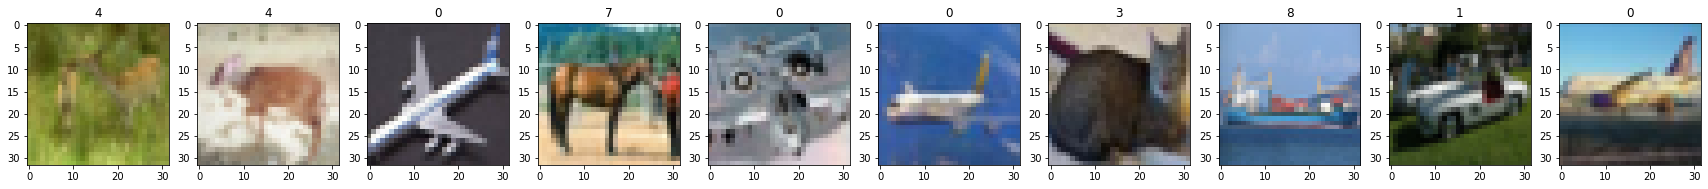

In [9]:
show_images(images, labels)

Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [10]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

## Определение класса сверточной нейросети

Импортируем нужные модули для обучения сети:

In [11]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F
# метрика качества 
from sklearn.metrics import accuracy_score

Объявим сверточную нейросеть.

Наша нейронная сеть будет содержать четыре слоя: два сверточных и два полносвязных. Также после первого сверточного слоя добавим pooling. В качестве функции активации для внутренних слоев будем использовать ReLU.

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # размер исходной картинки 32х32

        # conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), padding=1) #32x32
        # pool
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) #16x16
        # conv 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) #14x14
        
        # flatten
        self.flatten = nn.Flatten()

        # linear 1
        self.fc1 = nn.Linear(14 * 14 * 9, 128)
        # linear 2
        self.fc2 = nn.Linear(128, 10)

    
    def forward(self, x):
        # forward pass сети

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [13]:
# объявляем сеть
conv_net = ConvNet()

## Обучение нейросети

In [14]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

Напишем функцию обучения сети:

In [15]:
from IPython.display import clear_output

def evaluate(model, dataloader, loss_fn=None, name='test'):
    
    y_pred_list = []
    y_true_list = []

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        with torch.no_grad():
            logits = model(X_batch)
            
            loss=None
            if loss_fn is not None:
                loss = loss_fn(logits, y_batch) 
                loss = loss.item()
            
            y_pred = torch.argmax(logits, dim=1)
            
        y_pred_list.extend(y_pred.numpy())
        y_true_list.extend(y_batch.numpy())
            
    
    accuracy = accuracy_score(y_pred_list, y_true_list)
            
    return accuracy, loss

def train(model, loss_fn, optimizer, n_epoch=3):
    
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
    
    # цикл обучения сети
    for epoch in range(n_epoch):

        model.train(True)
        
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch) 
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch) 
            
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # выведем лосс на график раз в 50 итераций обучения
            if i % 50 == 0:
                
                fig, axes = plt.subplots(2, 2, figsize=(14, 10))
                
                train_losses.append(loss.item())
                
                # вычислим accuracy на текущем train батче
                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = accuracy_score(y_batch.numpy(), model_answers)
                train_accuracies.append(train_accuracy)
                
                train_iterations = np.array(range(len(train_losses)))*50
                
                # отрисовываем train_losses
                axes[0, 0].plot(train_iterations, train_losses)
                axes[0, 0].set_title('Train losses')
                axes[0, 0].set(xlabel='Iterations', ylabel='Loss')
                
                # отрисовываем train_accuracies
                axes[0, 1].plot(train_iterations, train_accuracies)
                axes[0, 1].set_title('Train accuracies')
                axes[0, 1].set(xlabel='Iterations', ylabel='Accuracy')
                
                val_iterations = np.array(range(len(val_losses)))*50
                
                axes[1, 0].plot(val_iterations, val_losses)
                axes[1, 0].set_title('Val losses')
                axes[1, 0].set(xlabel='Iterations', ylabel='Loss')
                
                axes[1, 1].plot(val_iterations, val_accuracies)
                axes[1, 1].set_title('Val accuracies')
                axes[1, 1].set(xlabel='Iterations', ylabel='Accuracy')
                
                plt.show()
                
                clear_output(wait=True)

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn, name='val')
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
    return model, train_losses, val_losses, val_accuracies

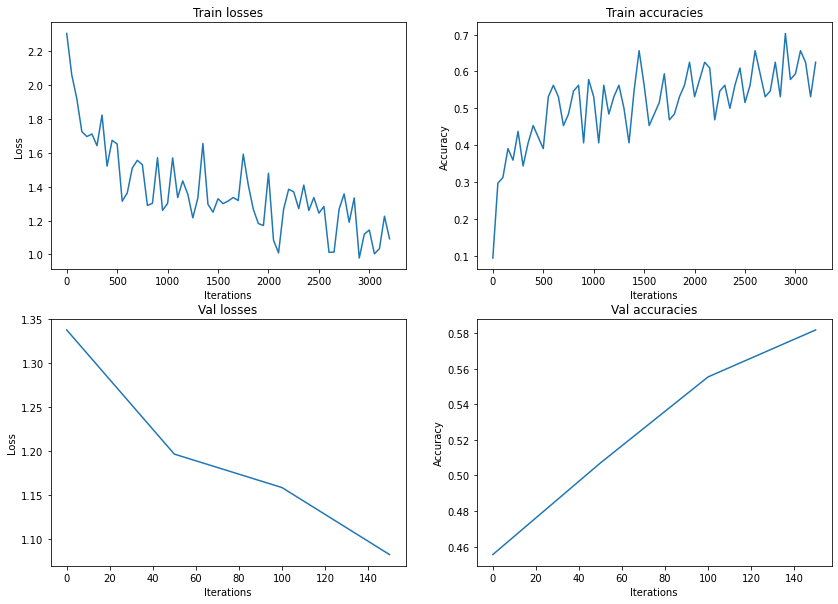

In [16]:
conv_net, train_losses_conv, val_losses_conv, val_accuracies_conv = train(conv_net, loss_fn, optimizer, n_epoch=5)

Построим графики лоссов на трейне и на тесте:

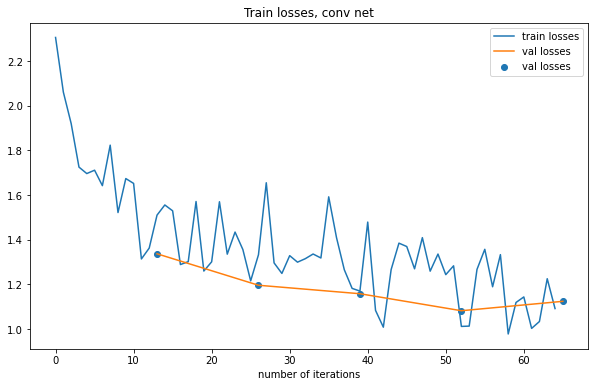

In [17]:
plt.figure(figsize=(10,6))
plt.title('Train losses, conv net')
plt.plot(np.arange(len(train_losses_conv)), train_losses_conv, label='train losses')
plt.plot(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)), 
         val_losses_conv, label='val losses')
plt.scatter(np.arange(1, len(val_losses_conv) + 1) * (len(train_losses_conv) // len(val_losses_conv)), 
         val_losses_conv, label='val losses')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

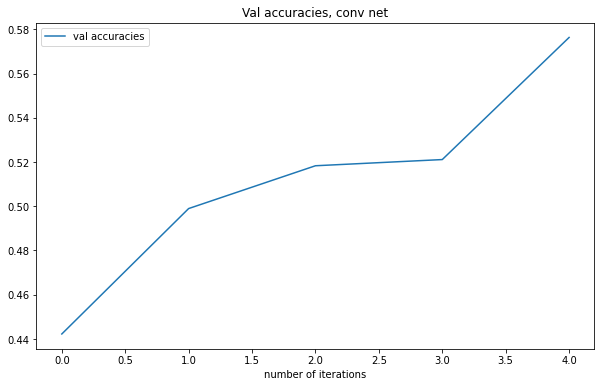

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Val accuracies, conv net')
plt.plot(np.arange(len(val_accuracies_conv)), val_accuracies_conv, label='val accuracies')
plt.xlabel('number of iterations')
plt.legend()
plt.show()

Посчитаем accuracy на train и test:

In [ ]:
train_accuracy, _ = evaluate(conv_net, train_loader, name='train');
print('Train accuracy is', train_accuracy)

Train accuracy is 0.5763


In [ ]:
test_accuracy, _ = evaluate(conv_net, test_loader, name='test');
print('Test accuracy is', test_accuracy)

Test accuracy is 0.5518
